#Stock Price Forecasting

**Dataset**: Apple (AAPL) daily OHLCV from 2015-01-01 to 2025-01-01 (Yahoo Finance).
**Author**: Md Mahmudur Rahman
**Date**: October 04, 2025

This notebook includes:
- Data preprocessing and feature engineering.
- Model training (ARIMA, LSTM).
- Rolling-window evaluation.
- Forecast plots.
- Model export for Hugging Face Space.

**Live**: [Hugging Face Space — DataSynthis_ML_JobTask](https://huggingface.co/spaces/mrshibly/DataSynthis_Job_task)

#Library Import

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

#Dataset Import

In [19]:
!pip install yfinance
import yfinance as yf

df = yf.download("AAPL", start="2015-01-01", end="2025-01-01")  # Apple stock
df = df.reset_index()[['Date','Close']]
display(df.head())

[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,AAPL
0,2015-01-02,24.261049
1,2015-01-05,23.577576
2,2015-01-06,23.579794
3,2015-01-07,23.910435
4,2015-01-08,24.829134


In [20]:
df.to_csv('aapl_stock_data.csv', index=False)
print("DataFrame saved to 'aapl_stock_data.csv'")

DataFrame saved to 'aapl_stock_data.csv'


# EDA

In [21]:
# Display the first few rows
print("First 5 rows of the DataFrame:")
display(df.head())

# Check data types and missing values
print("\nData types and missing values:")
display(df.info())

# Get descriptive statistics
print("\nDescriptive statistics:")
display(df.describe())

First 5 rows of the DataFrame:


Price,Date,Close
Ticker,,AAPL
0,2015-01-02,24.261049
1,2015-01-05,23.577576
2,2015-01-06,23.579794
3,2015-01-07,23.910435
4,2015-01-08,24.829134



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   (Date, )       2516 non-null   datetime64[ns]
 1   (Close, AAPL)  2516 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


None


Descriptive statistics:


Price,Date,Close
Ticker,,AAPL
count,2516,2516.000000
mean,2019-12-31 19:03:31.764706048,93.949921
min,2015-01-02 00:00:00,20.624046
25%,2017-07-02 06:00:00,35.257092
50%,2020-01-01 00:00:00,64.450432
75%,2022-06-30 06:00:00,150.379642
max,2024-12-31 00:00:00,258.103729
std,NaN,65.504728


In [22]:
df['Close'] = df['Close'].round(2)
display(df.head())

Price,Date,Close
Ticker,,AAPL
0,2015-01-02,24.26
1,2015-01-05,23.58
2,2015-01-06,23.58
3,2015-01-07,23.91
4,2015-01-08,24.83


In [23]:
# !pip install ydata-profiling
# from ydata_profiling import ProfileReport

# # Generate the profiling report
# profile = ProfileReport(df, title="Pandas Profiling Report")

# # Save the report to an HTML file
# profile.to_file("ydata_profiling_report.html")

# print("YData Profiling report saved as 'ydata_profiling_report.html'")

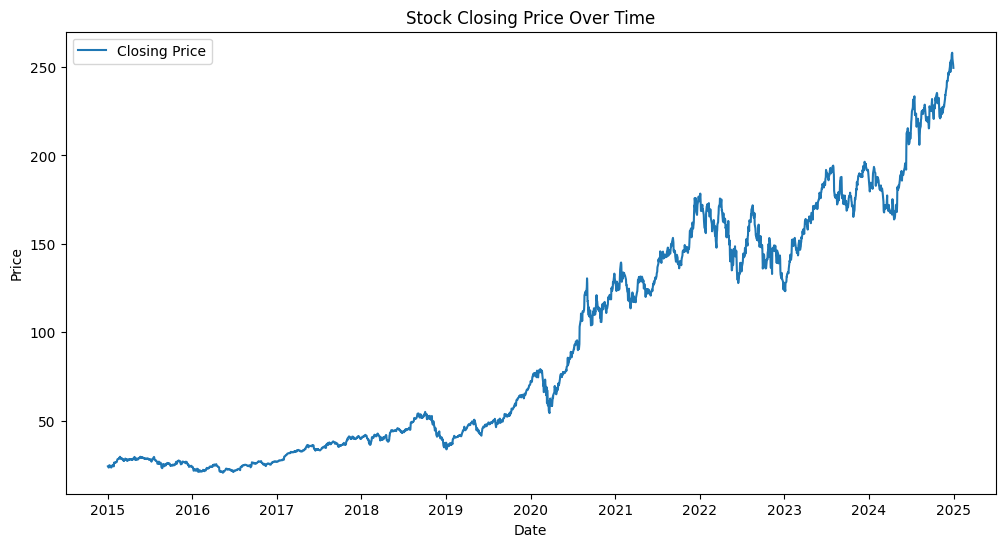

In [26]:
# Plot closing price history
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

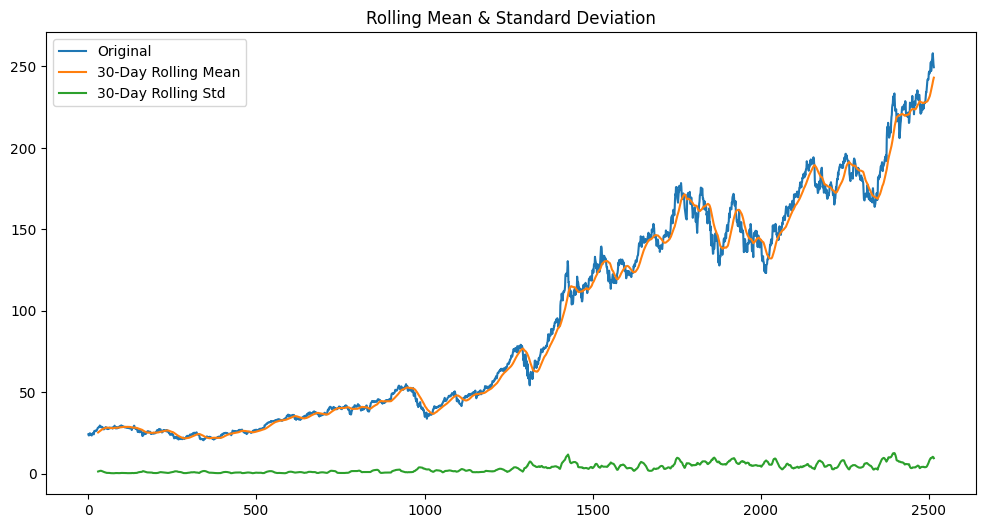

In [27]:
# Check rolling mean & std (for stationarity)
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='30-Day Rolling Mean')
plt.plot(rolling_std, label='30-Day Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Preprocessing & Train-Test Split

Missing values: Price  Ticker
Close  AAPL      0
dtype: int64
Train: 2012 days, Test: 504 days


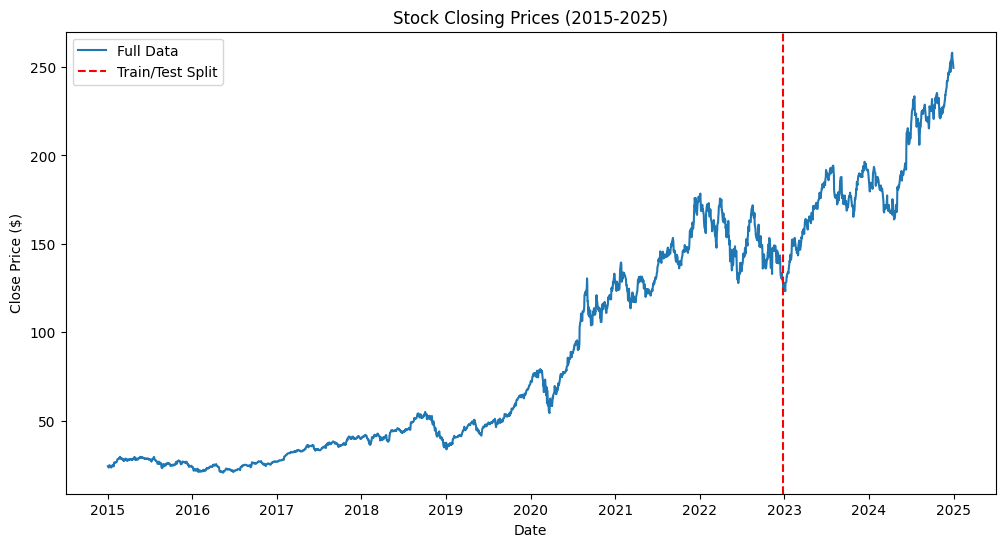

In [28]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()

# Check for missing values
print("Missing values:", df.isna().sum())

# Split: 80% train, 20% test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print(f'Train: {len(train)} days, Test: {len(test)} days')

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Full Data')
plt.axvline(train.index[-1], color='r', linestyle='--', label='Train/Test Split')
plt.title('Stock Closing Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

# ARIMA model

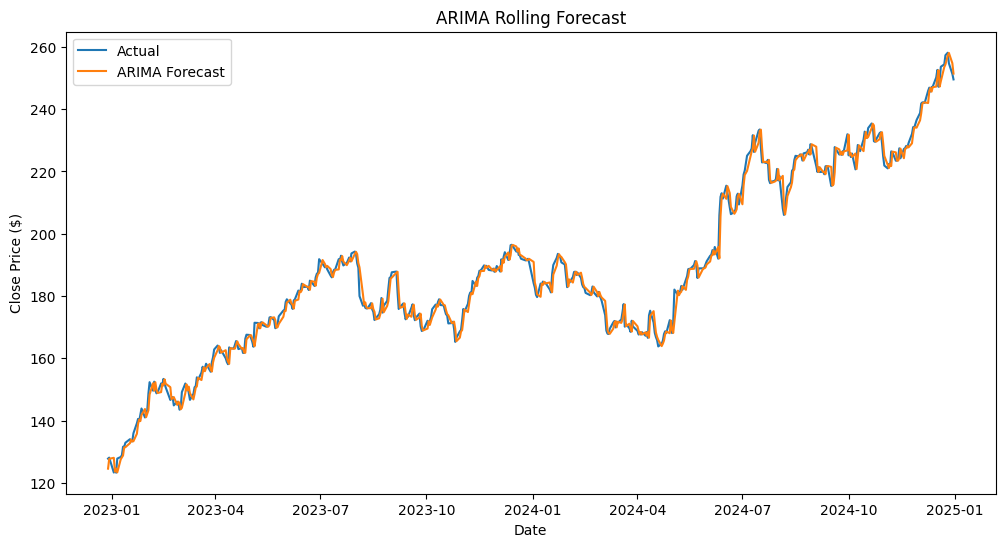

In [29]:
# Walk-forward validation for ARIMA
def walk_forward_arima(train, test, order=(1,1,1)):
    history = list(train['Close'].values) # Convert to list of values
    predictions = []
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
        except Exception as e:
            # Fallback: naive forecast (last value)
            predictions.append(history[-1])
            print(f'ARIMA fit failed at step {t}: {e}')
        history.append(test['Close'].iloc[t])
    return np.array(predictions)

# Run ARIMA
arima_preds = walk_forward_arima(train, test)

# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_preds, label='ARIMA Forecast')
plt.title('ARIMA Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

In [30]:
import pickle

# Train the final ARIMA model on the entire training data
final_arima_model = ARIMA(train['Close'], order=(1,1,1)) # Use the best order found during walk-forward validation
final_arima_model_fit = final_arima_model.fit()

# Save the trained ARIMA model
with open('arima_model.pkl', 'wb') as pkl:
    pickle.dump(final_arima_model_fit, pkl)

print("ARIMA model trained on full training data and saved as 'arima_model.pkl'")

# You can load the model later using:
# with open('arima_model.pkl', 'rb') as pkl:
#     loaded_arima_model = pickle.load(pkl)

ARIMA model trained on full training data and saved as 'arima_model.pkl'


# LSTM Model

Epoch 10/100, Loss: 0.1413
Epoch 20/100, Loss: 0.0850
Epoch 30/100, Loss: 0.0562
Epoch 40/100, Loss: 0.0133
Epoch 50/100, Loss: 0.0054
Epoch 60/100, Loss: 0.0038
Epoch 70/100, Loss: 0.0034
Epoch 80/100, Loss: 0.0030
Epoch 90/100, Loss: 0.0027
Epoch 100/100, Loss: 0.0024


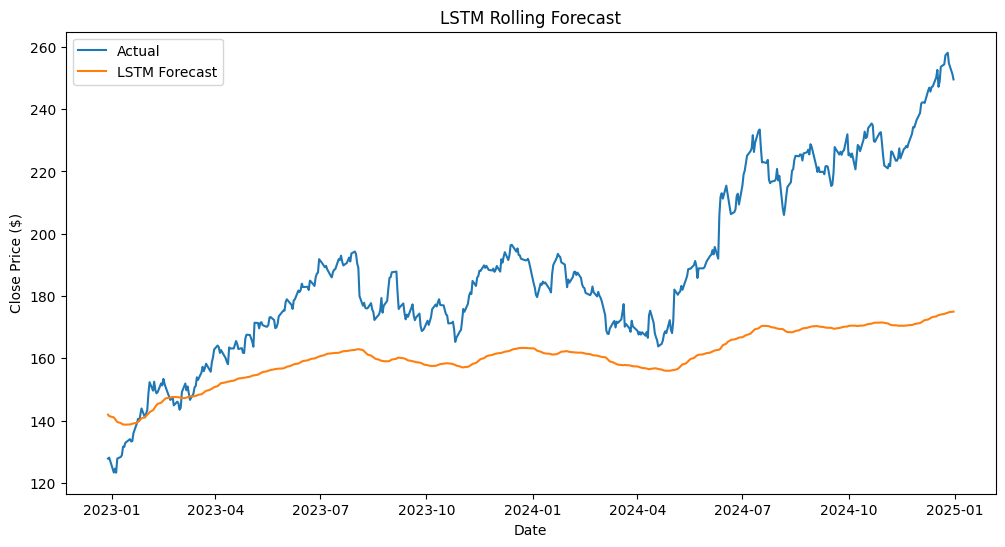

In [31]:
# Prepare sequences for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train['Close'].values.reshape(-1, 1))

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# Define LSTM model with dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers # Store num_layers
        self.hidden_size = hidden_size # Store hidden_size

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Use self.num_layers and self.hidden_size
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Use self.num_layers and self.hidden_size
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Initialize model, loss, optimizer
model = LSTMModel(num_layers=2)  # Increased layers for better learning
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train LSTM
epochs = 100  # Increased epochs
for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Save model weights for deployment
torch.save(model.state_dict(), 'lstm_model.pth')

# Rolling forecast
test_scaled = scaler.transform(test['Close'].values.reshape(-1, 1))
lstm_preds_scaled = []
current_seq = torch.from_numpy(scaled_data[-seq_length:].reshape(1, seq_length, 1)).float()

for i in range(len(test)):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()
        lstm_preds_scaled.append(pred_scaled)
    actual_scaled = torch.from_numpy(test_scaled[i].reshape(1, 1)).float()
    current_seq = torch.cat((current_seq[:, 1:, :], actual_scaled.unsqueeze(0)), dim=1)

lstm_preds = scaler.inverse_transform(np.array(lstm_preds_scaled).reshape(-1, 1)).flatten()

# Plot LSTM forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, lstm_preds, label='LSTM Forecast')
plt.title('LSTM Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

# Model Comparison

In [32]:
# Calculate metrics
rmse_arima = np.sqrt(mean_squared_error(test['Close'], arima_preds))
mape_arima = mean_absolute_percentage_error(test['Close'], arima_preds) * 100
rmse_lstm = np.sqrt(mean_squared_error(test['Close'], lstm_preds))
mape_lstm = mean_absolute_percentage_error(test['Close'], lstm_preds) * 100

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [rmse_arima, rmse_lstm],
    'MAPE (%)': [mape_arima, mape_lstm]
})
print("\nPerformance Comparison:")
print(comparison)


Performance Comparison:
   Model       RMSE   MAPE (%)
0  ARIMA   2.551856   1.017763
1   LSTM  34.691008  14.010142


# Rolling Window Evaluation

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(model, data, scaler=None, seq_length=None):
    tscv = TimeSeriesSplit(n_splits=5)
    errors = []
    for train_index, test_index in tscv.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        if isinstance(model, ARIMA):
            # ARIMA requires data as values
            history = list(train_data['Close'].values)
            predictions = []
            for t in range(len(test_data)):
                try:
                    model_fit = ARIMA(history, order=model.order).fit()
                    yhat = model_fit.forecast()[0]
                    predictions.append(yhat)
                except Exception as e:
                    predictions.append(history[-1]) # Fallback
                    print(f'ARIMA fit failed at step {t}: {e}')
                history.append(test_data['Close'].iloc[t])
            actuals = test_data['Close'].values

        elif isinstance(model, nn.Module):
            # LSTM requires scaled data and sequences
            train_scaled = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))
            test_scaled = scaler.transform(test_data['Close'].values.reshape(-1, 1))

            X_train, y_train = create_sequences(train_scaled, seq_length)
            X_train = torch.from_numpy(X_train).float()
            y_train = torch.from_numpy(y_train).float()

            # Train LSTM model
            lstm_model = LSTMModel(num_layers=2)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

            epochs = 50 # Reduced epochs for quicker cross-validation
            for epoch in range(epochs):
                lstm_model.train()
                outputs = lstm_model(X_train)
                loss = criterion(outputs, y_train)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Make predictions
            lstm_preds_scaled = []
            current_seq = torch.from_numpy(train_scaled[-seq_length:].reshape(1, seq_length, 1)).float()

            for i in range(len(test_scaled)):
                lstm_model.eval()
                with torch.no_grad():
                    pred_scaled = lstm_model(current_seq).item()
                    lstm_preds_scaled.append(pred_scaled)
                actual_scaled = torch.from_numpy(test_scaled[i].reshape(1, 1)).float()
                current_seq = torch.cat((current_seq[:, 1:, :], actual_scaled.unsqueeze(0)), dim=1)

            predictions = scaler.inverse_transform(np.array(lstm_preds_scaled).reshape(-1, 1)).flatten()
            actuals = test_data['Close'].values

        else:
            raise ValueError("Unsupported model type")

        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        errors.append(rmse)
    return np.mean(errors)

# Evaluate ARIMA with rolling window
mean_rmse_arima_rolling = rolling_window_evaluation(ARIMA([0], order=(1,1,1)), df)
print(f'Mean RMSE (ARIMA Rolling Window): {mean_rmse_arima_rolling:.4f}')

# Evaluate LSTM with rolling window
# Need to pass the scaler and seq_length used for LSTM
mean_rmse_lstm_rolling = rolling_window_evaluation(LSTMModel(num_layers=2), df, scaler, seq_length)
print(f'Mean RMSE (LSTM Rolling Window): {mean_rmse_lstm_rolling:.4f}')

Mean RMSE (ARIMA Rolling Window): 1.8456
Mean RMSE (LSTM Rolling Window): 10.9905


# Summary

*  ARIMA is the better choice for forecasting AAPL stock prices, offering superior accuracy and stability.
*  LSTM could improve with more data or additional features (trading volume, market sentiment), but ARIMA is recommended for reliable predictions in this scenario.

